In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
            confusion_matrix, roc_auc_score, classification_report, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                            AdaBoostClassifier, BaggingClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
file_path = 'Strokesdataset.csv'
stroke_data = pd.read_csv(file_path)

In [3]:
# Drop the 'id' column
stroke_data.drop(columns=['id'], inplace=True)

In [4]:
# Checking for null values
stroke_data.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [5]:
# Checking for duplicates
stroke_data.duplicated().sum()

0

In [ ]:
# Handling missing values in the BMI column by filling with the median BMI value
stroke_data['bmi'].fillna(stroke_data['bmi'].median(), inplace=True)
stroke_data['smoking_status'].fillna(stroke_data['smoking_status'].mode()[0], 
                                    inplace=True)

In [ ]:
# Encoding categorical variables
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type',
            'Residence_type', 'smoking_status']:
    le = LabelEncoder()
    stroke_data[column] = le.fit_transform(stroke_data[column])
    label_encoders[column] = le

In [8]:
stroke_data['smoking_status']

0        1
1        1
2        1
3        0
4        1
        ..
43395    1
43396    0
43397    0
43398    1
43399    1
Name: smoking_status, Length: 43400, dtype: int32

In [ ]:
# Scaling numerical features
scaler = StandardScaler()
stroke_data[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(stroke_data[['age',
                                                                'avg_glucose_level', 'bmi']])

In [10]:
# Splitting the data into features and target variable
X = stroke_data.drop(columns=['stroke'])
y = stroke_data['stroke']

In [11]:
# Count the occurrences of each class before SMOTE
class_counts_before = y.value_counts()

In [12]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
# Count the occurrences of each class after SMOTE
class_counts_after = y_resampled.value_counts()

In [14]:
# Create a DataFrame to hold the class counts
class_counts_df = pd.DataFrame({
    'Before SMOTE': class_counts_before,
    'After SMOTE': class_counts_after
}).reset_index()

In [15]:
class_counts_df.columns = ['Class', 'Before SMOTE', 'After SMOTE']

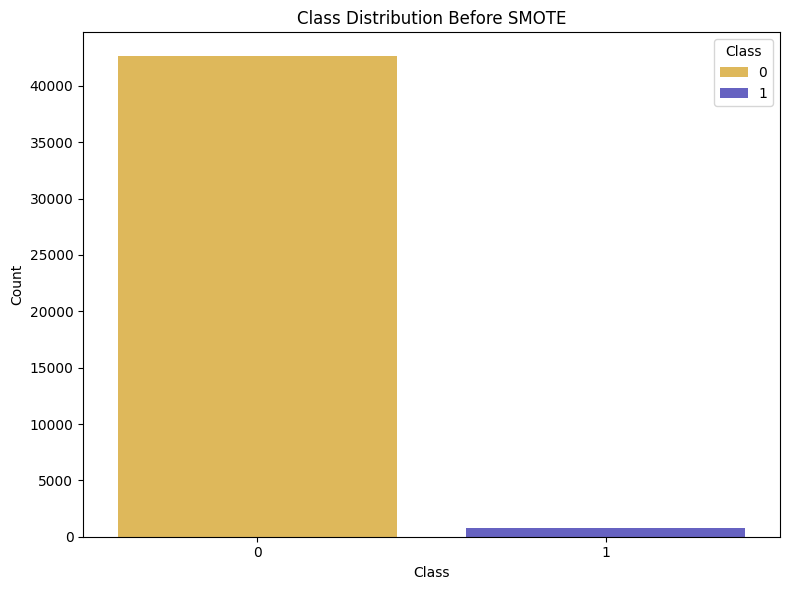

In [ ]:
# Plot for class counts before SMOTE
plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Before SMOTE', data=class_counts_df,
            hue='Class', palette=['#f4c145', '#5752d1'], dodge=False)
plt.title('Class Distribution Before SMOTE')
plt.ylabel('Count')
plt.xlabel('Class')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

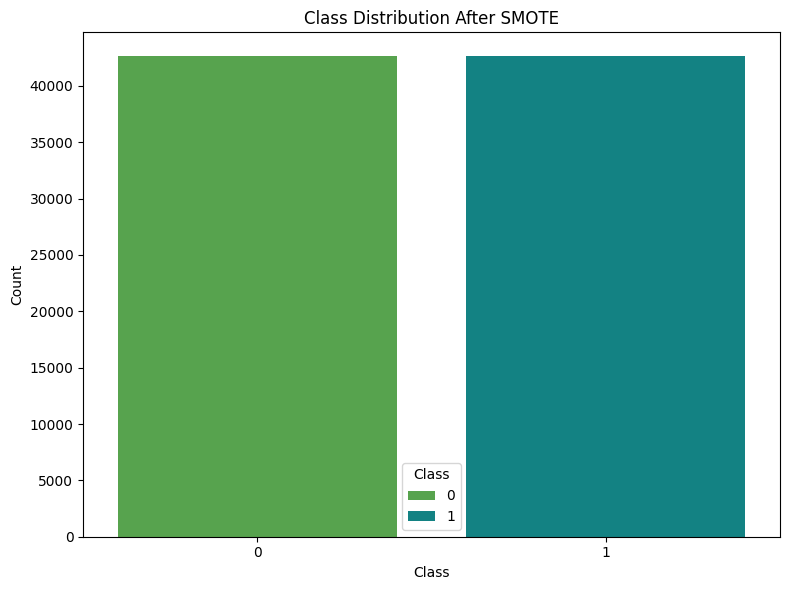

In [ ]:
# Plot for class counts after SMOTE
plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='After SMOTE', data=class_counts_df,
            hue='Class', palette=["#4cb140","#009596"], dodge=False)
plt.title('Class Distribution After SMOTE')
plt.ylabel('Count')
plt.xlabel('Class')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [ ]:
# Splitting the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42)

In [ ]:
# Dictionary to store the models and their results
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(),
                                n_estimators=50, random_state=42),
    'Voting': VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ], voting='soft')
}

In [20]:
results = []
roc_curves = {}

In [21]:
# Training and evaluating the models
for model_name, model in models.items():
    print(f"----------{model_name}----------")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(
        model, "predict_proba") else None

    model_results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba \
                                                    is not None else 'N/A',
        # Convert to list for easier JSON serialization
        'Confusion Matrix': confusion_matrix(y_test, y_pred).tolist(),
        'Classification Report': classification_report(y_test, y_pred, zero_division=0)
    }
    results.append(model_results)

    # Store ROC curve data
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_curves[model_name] = (fpr, tpr, auc(fpr, tpr))

----------Logistic Regression----------
----------Decision Tree----------
----------Random Forest----------
----------Gradient Boosting----------
----------AdaBoost----------
----------XGBoost----------
----------Support Vector Machine----------
----------K-Nearest Neighbors----------
----------Naive Bayes----------
----------Bagging----------
----------Voting----------


In [22]:
# Display results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                     Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0      Logistic Regression  0.777732   0.757802  0.818182  0.786835  0.852694   
1            Decision Tree  0.972136   0.969084  0.975547  0.972305  0.972126   
2            Random Forest  0.965155   0.949271  0.983035  0.965858  0.995458   
3        Gradient Boosting  0.847363   0.822852  0.886393  0.853441  0.935849   
4                 AdaBoost  0.798205   0.772548  0.846847  0.807993  0.888262   
5                  XGBoost  0.921511   0.943303  0.897391  0.919775  0.982512   
6   Support Vector Machine  0.817622   0.778986  0.888265  0.830044  0.893296   
7      K-Nearest Neighbors  0.923388   0.874135  0.989704  0.928336  0.964757   
8              Naive Bayes  0.754854   0.737237  0.794080  0.764603  0.816560   
9                  Bagging  0.983809   0.987504  0.980110  0.983793  0.995740   
10                  Voting  0.875345   0.843937  0.921844  0.881172  0.963457   

                Confusion M

In [23]:
# Identify the best model based on a selected metric, e.g., F1 Score
best_model = results_df.loc[results_df['F1 Score'].idxmax()]

In [24]:
print("Best Model Based on F1 Score:")
print(best_model)

Best Model Based on F1 Score:
Model                                                              Bagging
Accuracy                                                          0.983809
Precision                                                         0.987504
Recall                                                             0.98011
F1 Score                                                          0.983793
ROC AUC                                                            0.99574
Confusion Matrix                                [[8394, 106], [170, 8377]]
Classification Report                  precision    recall  f1-score   ...
Name: 9, dtype: object


In [25]:
# Print the metrics of the best model
print(f"\nModel: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']}")
print(f"Precision: {best_model['Precision']}")
print(f"Recall: {best_model['Recall']}")
print(f"F1 Score: {best_model['F1 Score']}")
print(f"ROC AUC: {best_model['ROC AUC']}")


Model: Bagging
Accuracy: 0.9838094679415733
Precision: 0.9875044206059177
Recall: 0.9801099801099801
F1 Score: 0.9837933059307105
ROC AUC: 0.9957402597402597


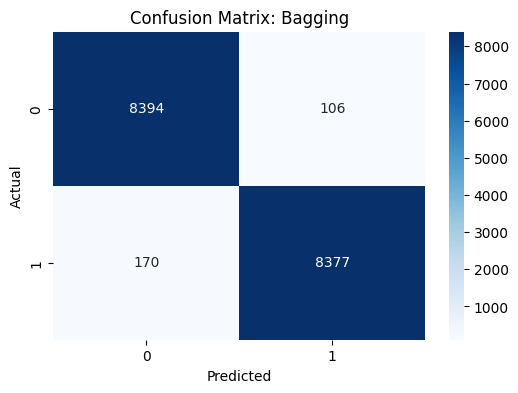

In [26]:
# Plot confusion matrix for the best model
best_model_cm = best_model['Confusion Matrix']
plt.figure(figsize=(6, 4))
sns.heatmap(best_model_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model["Model"]}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Print classification report for the best model
print(f"Classification Report for {best_model['Model']}:\n
    {best_model['Classification Report']}")

Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8500
           1       0.99      0.98      0.98      8547

    accuracy                           0.98     17047
   macro avg       0.98      0.98      0.98     17047
weighted avg       0.98      0.98      0.98     17047



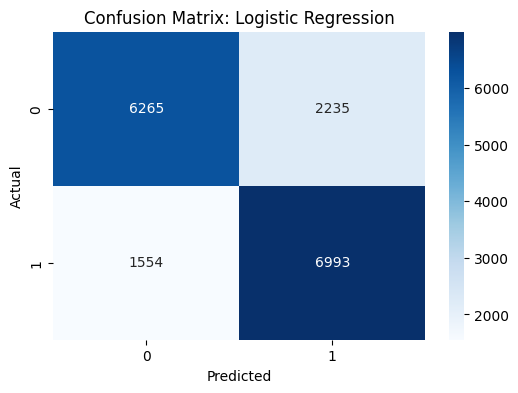

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      8500
           1       0.76      0.82      0.79      8547

    accuracy                           0.78     17047
   macro avg       0.78      0.78      0.78     17047
weighted avg       0.78      0.78      0.78     17047



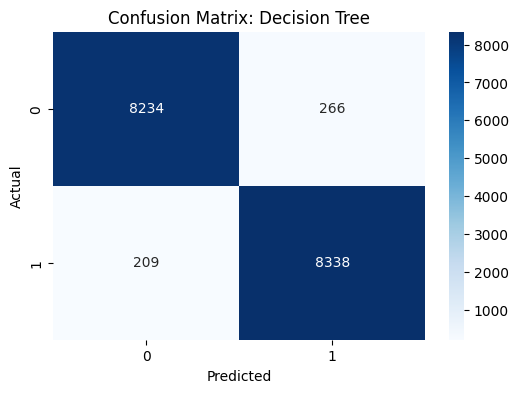

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8500
           1       0.97      0.98      0.97      8547

    accuracy                           0.97     17047
   macro avg       0.97      0.97      0.97     17047
weighted avg       0.97      0.97      0.97     17047



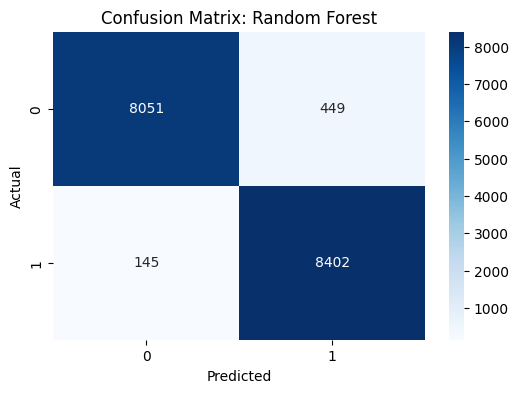

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      8500
           1       0.95      0.98      0.97      8547

    accuracy                           0.97     17047
   macro avg       0.97      0.97      0.97     17047
weighted avg       0.97      0.97      0.97     17047



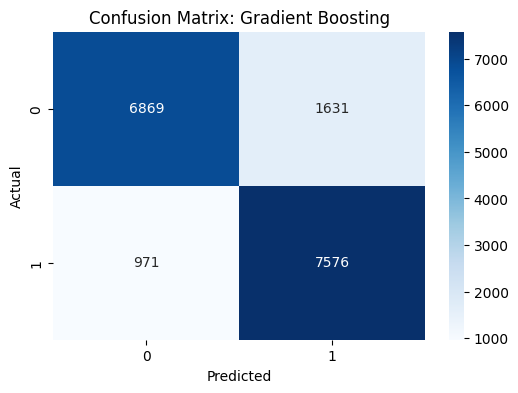

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      8500
           1       0.82      0.89      0.85      8547

    accuracy                           0.85     17047
   macro avg       0.85      0.85      0.85     17047
weighted avg       0.85      0.85      0.85     17047



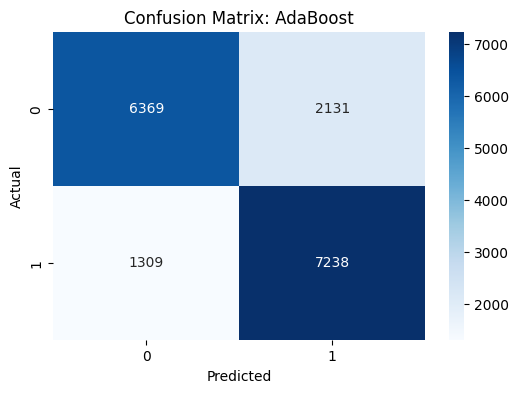

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      8500
           1       0.77      0.85      0.81      8547

    accuracy                           0.80     17047
   macro avg       0.80      0.80      0.80     17047
weighted avg       0.80      0.80      0.80     17047



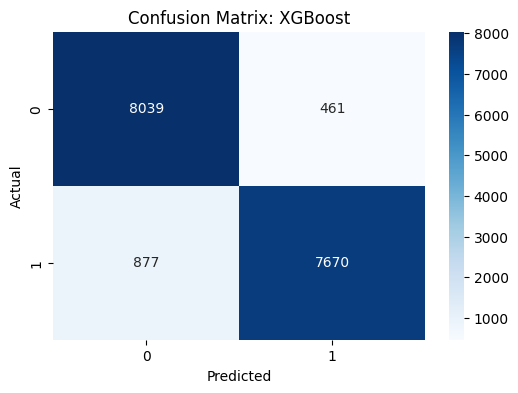

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      8500
           1       0.94      0.90      0.92      8547

    accuracy                           0.92     17047
   macro avg       0.92      0.92      0.92     17047
weighted avg       0.92      0.92      0.92     17047



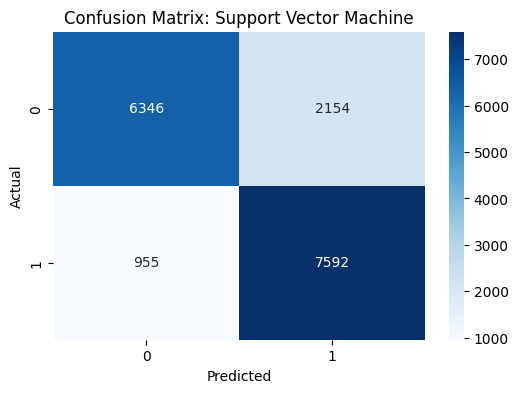

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      8500
           1       0.78      0.89      0.83      8547

    accuracy                           0.82     17047
   macro avg       0.82      0.82      0.82     17047
weighted avg       0.82      0.82      0.82     17047



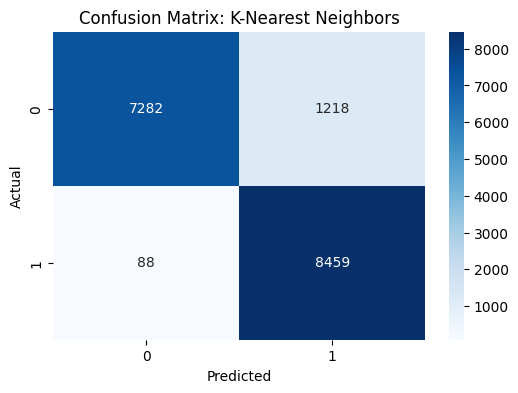

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      8500
           1       0.87      0.99      0.93      8547

    accuracy                           0.92     17047
   macro avg       0.93      0.92      0.92     17047
weighted avg       0.93      0.92      0.92     17047



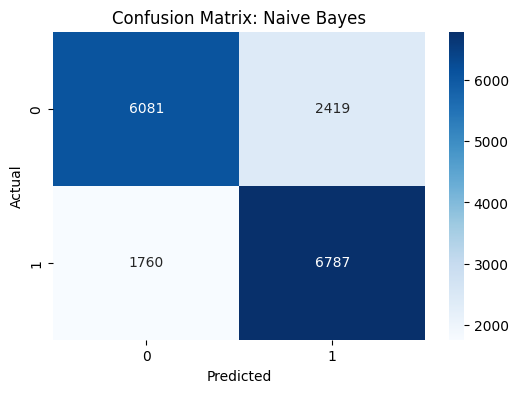

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.78      0.72      0.74      8500
           1       0.74      0.79      0.76      8547

    accuracy                           0.75     17047
   macro avg       0.76      0.75      0.75     17047
weighted avg       0.76      0.75      0.75     17047



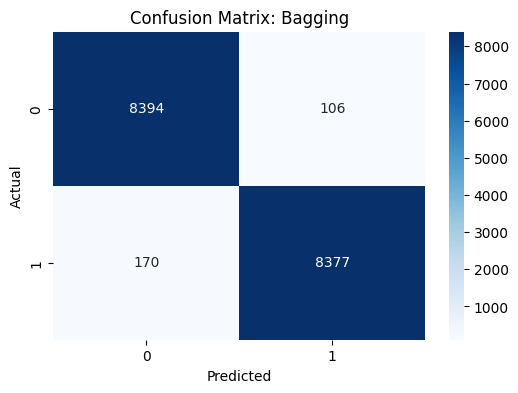

Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8500
           1       0.99      0.98      0.98      8547

    accuracy                           0.98     17047
   macro avg       0.98      0.98      0.98     17047
weighted avg       0.98      0.98      0.98     17047



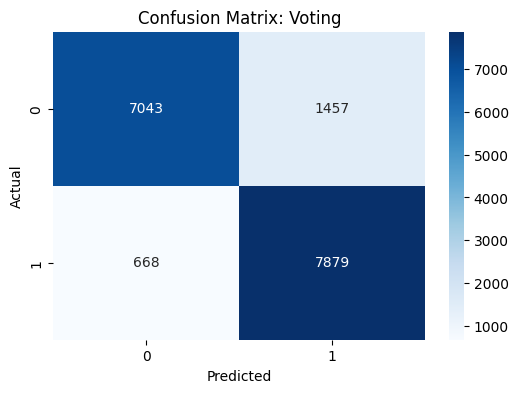

Classification Report for Voting:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      8500
           1       0.84      0.92      0.88      8547

    accuracy                           0.88     17047
   macro avg       0.88      0.88      0.88     17047
weighted avg       0.88      0.88      0.88     17047



In [30]:
# Plot confusion matrix for each model
for model_name in models.keys():
    cm = next(item['Confusion Matrix'] for item in results if
                item['Model'] == model_name)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report
    report = next(item['Classification Report'] for item in results
                if item['Model'] == model_name)
    print(f'Classification Report for {model_name}:\n{report}')

In [31]:
# Define a color palette
colors = sns.color_palette('husl', n_colors=len(roc_curves))

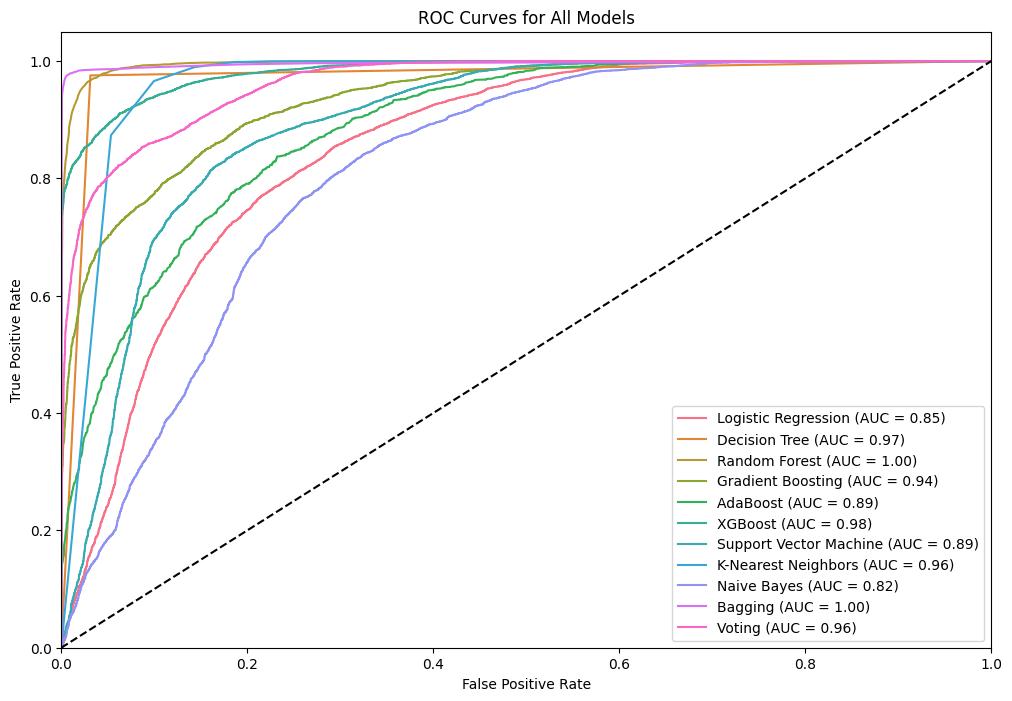

In [32]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 8))
for (model_name, (fpr, tpr, roc_auc)), color in zip(roc_curves.items(), colors):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

In [33]:
# Assign colors to each model based on the order in results_df
model_colors = {model: color for model, color in zip(results_df['Model'], colors)}

C:\Users\muhammad.abdullah.ai\AppData\Local\Temp\ipykernel_2416\793954673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df.sort_values(by='Accuracy',


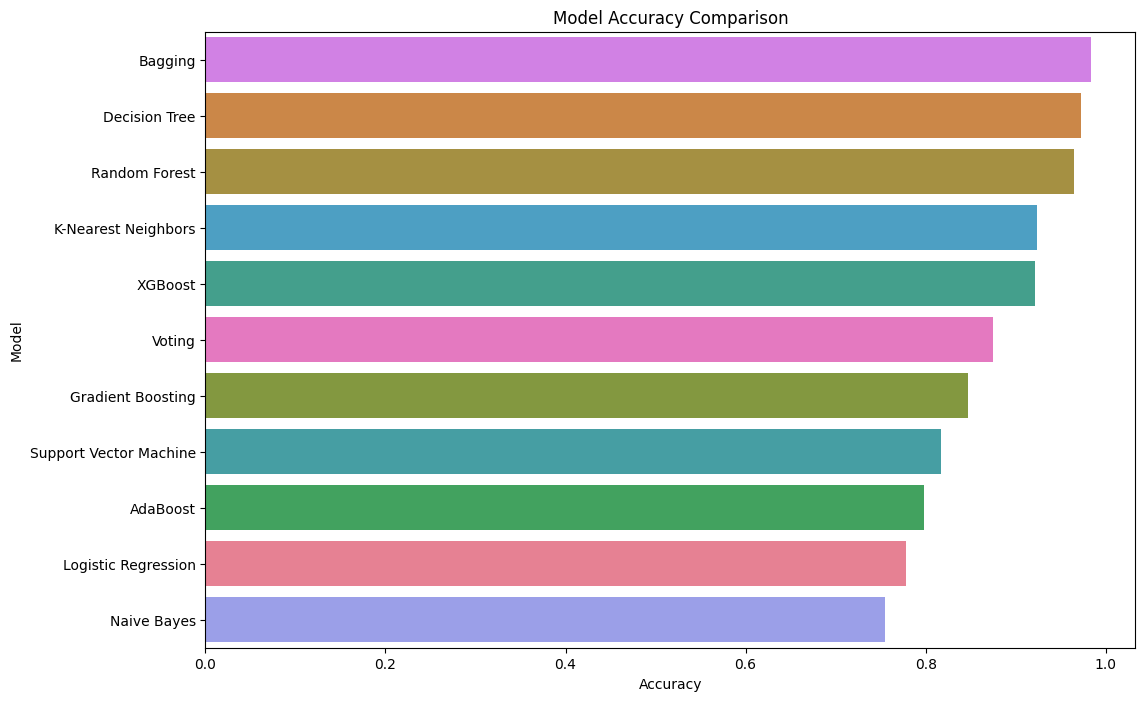

In [34]:
# Bar plot of model accuracies with the same color for each corresponding model
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=results_df.sort_values(by='Accuracy',
                                        ascending=False), palette=model_colors)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()